In [1]:
import json
import numpy as np
import os.path
from os.path import exists
import pandas as pd
from scipy.stats import gaussian_kde
from corner import corner

import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from matplotlib import style

simona_root = '/home/simona.miller/measuring-bbh-component-spin'

style.use(simona_root+'/Figures/plotting.mplstyle')

import sys
sys.path.append(simona_root+'/Figures')
from helper_functions import *

sys.path.append(simona_root+'/Data/IndividualInferenceOutput/inspect_results')
from inspect_results_helper_functions import * 

### Load in job lists

In [2]:
joblists = {}

pop_names = ['population1_highSpinPrecessing', 'population2_mediumSpin', 'population3_lowSpinAligned']

for pop in pop_names:
    f = f'{simona_root}/Code/IndividualInference/injlist_{pop}_' + str(400) + 'events.txt'
    jobs = np.loadtxt(f)    
    joblists[pop] = [int(job) for job in np.sort(jobs)]

### Load in the dicts with *all* the events

In [3]:
f_root = simona_root+'/Data/InjectedPopulationParameters/'
pop1_fullmass = pd.read_json(f_root+'population1_highSpinPrecessing_fullmassrange.json')
pop2_fullmass = pd.read_json(f_root+'population2_mediumSpin_fullmassrange.json')
pop3_fullmass = pd.read_json(f_root+'population3_lowSpinAligned_fullmassrange.json')

### Functions to generate the parameters we want to plot

In [4]:
def genParamDict(joblist, pop1, pop2, pop3): 
    
    params_dict = {}

    for i,pop in enumerate([pop1, pop2, pop3]):

        chis = []
        costs = []
        chieffs = []
        chips = []
        m1s = []
        m2s = []
        qs = []
        zs = []

        for job in joblist[pop_names[i]]:

            JOB_ID = int(job)

            # masses 
            m1 = pop.m1[JOB_ID]
            m2 = pop.m2[JOB_ID]
            m1s += [m1]
            m2s += [m2]

            # redshift
            zs += [pop.z[JOB_ID]]

            # spin magnitude
            chi1 = np.sqrt(pop.s1x[JOB_ID]**2 + pop.s1y[JOB_ID]**2 + pop.s1z[JOB_ID]**2)
            chi2 = np.sqrt(pop.s2x[JOB_ID]**2 + pop.s2y[JOB_ID]**2 + pop.s2z[JOB_ID]**2)
            chis += [chi1]
            chis += [chi2]

            # tilt angle
            cost1 = pop.s1z[JOB_ID]/chi1
            cost2 = pop.s2z[JOB_ID]/chi2
            costs += [cost1]
            costs += [cost2]

            # chi effective
            q = m2/m1
            qs += [q]
            chieff = calculate_chiEff(chi1, chi2, cost1, cost2, q)
            chieffs += [chieff]

            # chi p
            sint1 = np.sin(np.arccos(cost1))
            sint2 = np.sin(np.arccos(cost2))
            chip = calculate_chiP(chi1, chi2, sint1, sint2, q)
            chips += [chip]

        params_dict[pop_names[i]] = {
            'chi':chis, 
            'cost':costs, 
            'chieff':chieffs, 
            'chip':chips, 
            'm1':m1s,
            'm2':m2s,
            'q':qs,
            'z':zs
        }
        
    return params_dict

In [5]:
# Set up grids to evaluate KDEs on
m1_grid = np.linspace(6,85,500)
m2_grid =  np.linspace(6,85,500)
q_grid =  np.linspace(0,1,500)
z_grid =  np.linspace(0,1.5,500)

# make and evaluate kdes
m1_kde = reflective_kde_on_grid(np.concatenate((np.asarray(pop1_fullmass.m1), np.asarray(pop2_fullmass.m1), np.asarray(pop3_fullmass.m1))), m1_grid)
m2_kde = reflective_kde_on_grid(np.concatenate((np.asarray(pop1_fullmass.m2), np.asarray(pop2_fullmass.m2), np.asarray(pop3_fullmass.m2))), m2_grid)

q = np.concatenate((np.asarray(pop1_fullmass.m2/pop1_fullmass.m1),  np.asarray(pop2_fullmass.m2/pop2_fullmass.m1),  np.asarray(pop3_fullmass.m2/pop3_fullmass.m1)))
q_kde = reflective_kde_on_grid(q, q_grid)

z_kde =reflective_kde_on_grid(np.concatenate((np.asarray(pop1_fullmass.z), np.asarray(pop2_fullmass.z), np.asarray(pop3_fullmass.z))), z_grid)

# put KDEs into dict
kde_dict = {
    'm1':m1_kde, 
    'm2':m2_kde, 
    'q':q_kde, 
    'z':z_kde
}

### Generate parameter dict for injections and plot

In [6]:
param_dict = genParamDict(joblists, pop1_fullmass, pop2_fullmass, pop3_fullmass)

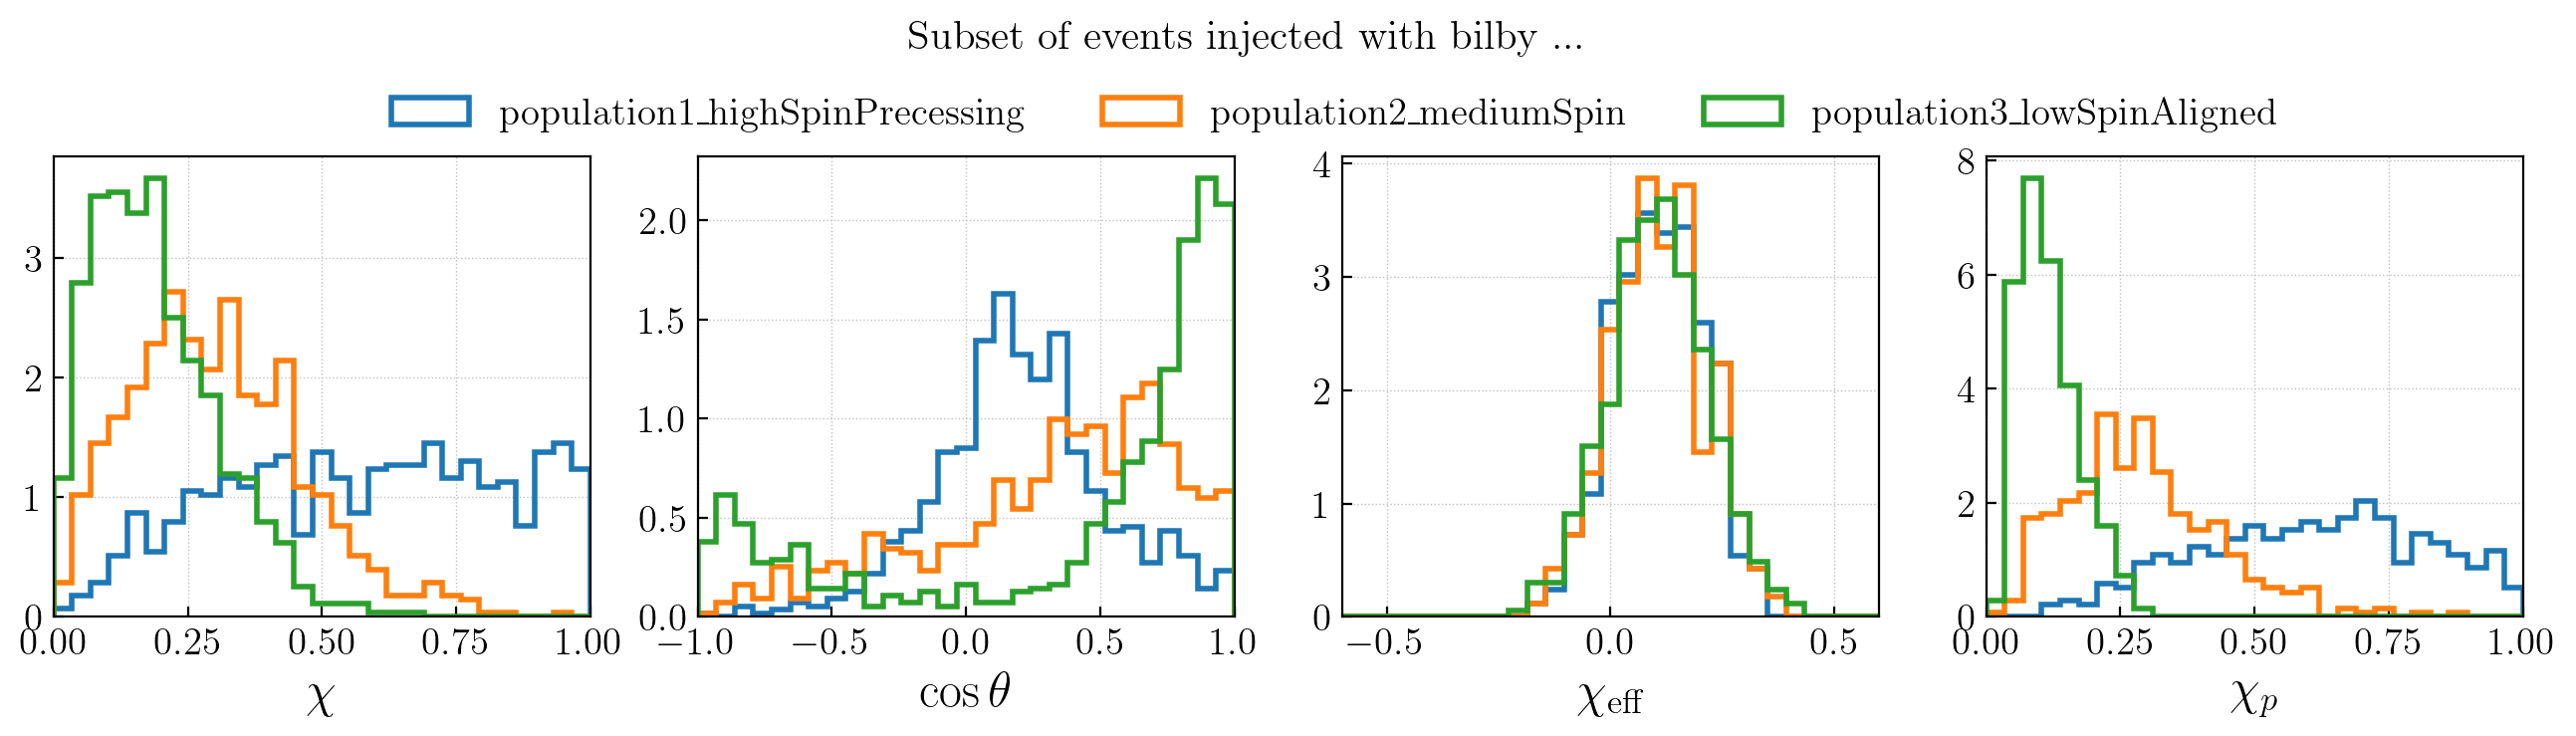

In [7]:
linstyles = ['-', '--', ':']
nbins = 30

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,3))

for i,pop in enumerate(pop_names):
        
    # spin magnitude
    axes[0].hist(param_dict[pop]['chi'], density=True, bins=np.linspace(0, 1, nbins), histtype='step', lw=2, label=pop, color=f'C{i}')
    axes[0].set_xlim(0,1)

    # tilt angle
    axes[1].hist(param_dict[pop]['cost'], density=True, bins=np.linspace(-1, 1, nbins), histtype='step', lw=2, color=f'C{i}')
    axes[1].set_xlim(-1,1)

    # chi effective
    axes[2].hist(param_dict[pop]['chieff'], density=True, bins=np.linspace(-0.6, 0.6, nbins), histtype='step', lw=2, color=f'C{i}')
    axes[2].set_xlim(-0.6,0.6)

    # chi p
    axes[3].hist(param_dict[pop]['chip'], density=True, bins=np.linspace(0, 1, nbins), histtype='step', lw=2, color=f'C{i}')
    axes[3].set_xlim(0, 1)
    
axes[0].legend(bbox_to_anchor=(0.6, 1.02, 1., .102), loc='lower left',
                      ncol=3,  borderaxespad=0.)
    
axes[0].set_xlabel(r'$\chi$')
axes[1].set_xlabel(r'$\cos\theta$')
axes[2].set_xlabel(r'$\chi_\mathrm{eff}$')
axes[3].set_xlabel(r'$\chi_p$')  

plt.suptitle('Subset of events injected with bilby ...', y=1.11, fontsize=15)

for ax in axes: 
    ax.grid(ls=':', color='silver', lw=0.5)
    
plt.show()

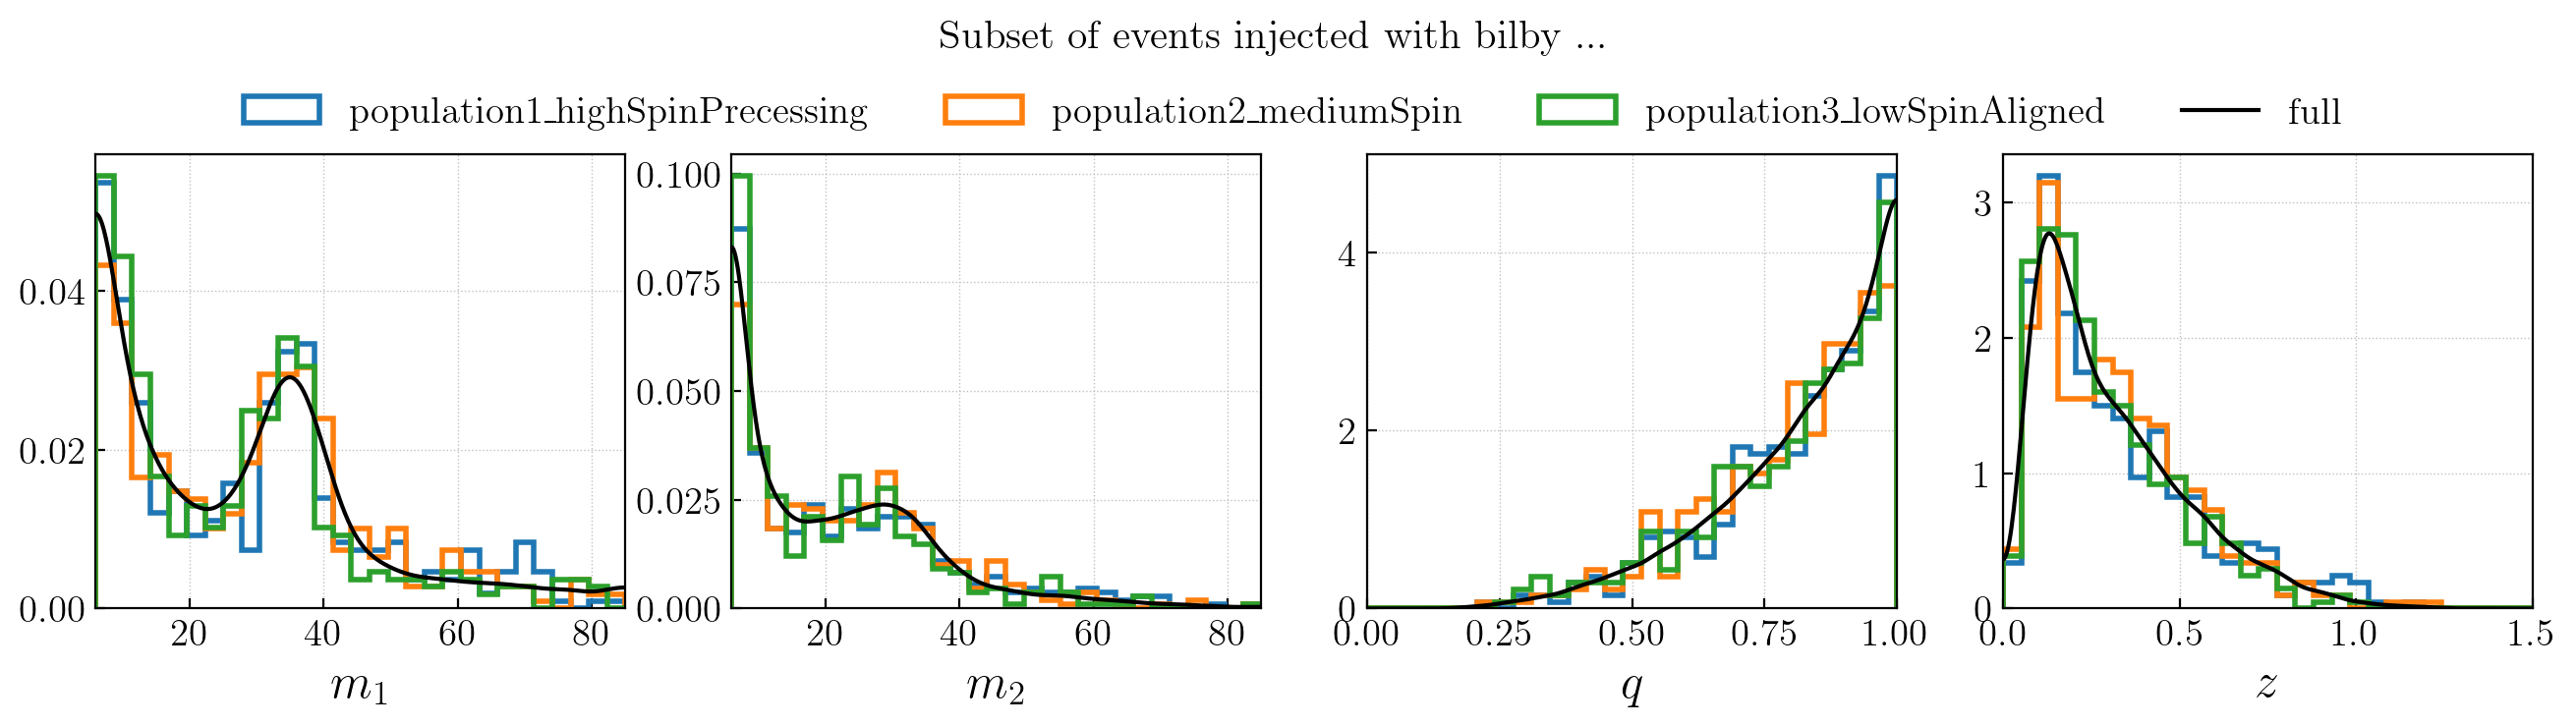

In [8]:
nbins = 30
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,3))
    
for i,pop in enumerate(pop_names):
    
    # m1
    mass_lims = [6,85]
    axes[0].hist(param_dict[pop]['m1'], density=True, bins=np.linspace(*mass_lims, nbins), histtype='step', lw=2, label=pop, color=f'C{i}')
    axes[0].set_xlim(*mass_lims)

    # m2
    axes[1].hist(param_dict[pop]['m2'], density=True, bins=np.linspace(*mass_lims, nbins), histtype='step', lw=2, label=pop, color=f'C{i}')
    axes[1].set_xlim(*mass_lims)

    # q
    axes[2].hist(param_dict[pop]['q'], density=True, bins=np.linspace(0, 1, nbins), histtype='step', lw=2, label=pop, color=f'C{i}')
    axes[2].set_xlim(0 ,1)

    # z
    axes[3].hist(param_dict[pop]['z'], density=True, bins=np.linspace(0, 1.5, nbins), histtype='step', lw=2, label=pop, color=f'C{i}')
    axes[3].set_xlim(0, 1.5)


axes[0].plot(m1_grid, kde_dict['m1'], color='k', label='full')
axes[1].plot(m2_grid, kde_dict['m2'], color='k')
axes[2].plot(q_grid, kde_dict['q'], color='k')
axes[3].plot(z_grid, kde_dict['z'], color='k')
    
axes[0].legend(bbox_to_anchor=(0.25, 1.02, 1., .102), loc='lower left',
                      ncol=4,  borderaxespad=0.)

axes[0].set_xlabel(r'$m_1$')
axes[1].set_xlabel(r'$m_2$')
axes[2].set_xlabel(r'$q$')
axes[3].set_xlabel(r'$z$')  

plt.suptitle('Subset of events injected with bilby ...', y=1.11, fontsize=15)

for ax in axes: 
    ax.grid(ls=':', color='silver', lw=0.5)
    
plt.show()

In [9]:
for i,pop in enumerate(pop_names):
    
    m1s = np.asarray(param_dict[pop]['m1'])
    m2s = np.asarray(param_dict[pop]['m2'])
        
    mtots = m1s+m2s
    
    print(f'{pop}:\nmin mtot = {min(mtots)}, event = {joblists[pop][np.argmin(mtots)]}\nmax mtot = {max(mtots)} event = {joblists[pop][np.argmax(mtots)]}\n')

population1_highSpinPrecessing:
min mtot = 12.0562198544, event = 2217
max mtot = 169.9828058337 event = 2357

population2_mediumSpin:
min mtot = 12.280241681500002, event = 9416
max mtot = 172.15310720079998 event = 7676

population3_lowSpinAligned:
min mtot = 12.012704100699999, event = 3760
max mtot = 173.5454152624 event = 9263

